In [1]:
import os
import sys
from pprint import pformat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import flopy

from tempfile import TemporaryDirectory

In [2]:
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name, "mf6lake")

In [12]:
name = "mf6lake"
h1, h2, Nlay,      N, L,    H, k = 100, 90, 10,       101, 400.0,     50.0, 1.0

In [4]:
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name="mf6", version="mf6", sim_ws=workspace)

In [5]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)])

In [6]:
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [7]:
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname="dis", nlay=Nlay, nrow=N, ncol=N,
    delr=delrow, delc=delcol, top=0.0, botm=bot,)

In [8]:
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname="npf", icelltype=1, k=k, save_flows=True)

In [ ]:
B = flopy.modflow.Modflow(name, exe_name="MF2005", model_ws=tmp_ws)
B.write_input() 

# __List__ __CHD__ __MF2005__

In [13]:
chd_rec = []
chd_rec.append(((0, int(N / 2), int(N / 2)), h2))
for layer in range(0, Nlay):
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), h1))
        chd_rec.append(((layer, row_col, N - 1), h1))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), h1))
            chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname="chd", maxbound=len(chd_rec), stress_period_data=chd_rec, save_flows=True,)

In [42]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper) # ra

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

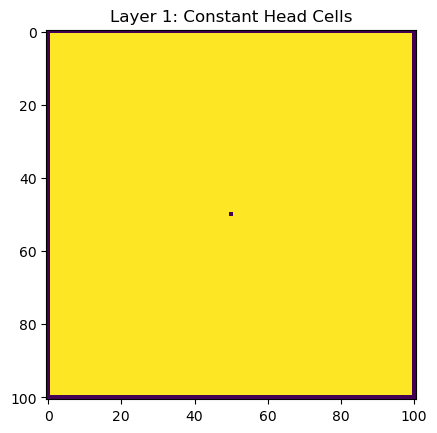

In [16]:
ibd = np.ones((Nlay, N, N), dtype=int)
for k, i, j in ra["cellid"]:
    ibd[k, i, j] = -1
ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation="none")
plt.title(f"Layer {ilay + 1}: Constant Head Cells")

# __Output__

In [18]:
headfile = f"{name}.hds"
head_filerecord = [headfile]
budgetfile = f"{name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc( gwf, pname="oc", saverecord=saverecord, head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord, printrecord=printrecord,)

In [19]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mf6lake...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package oc...


In [20]:
success, buff = sim.run_simulation(silent=True, report=True)
assert success, pformat(buff)

(0.0, 400.0, 0.0, 400.0)

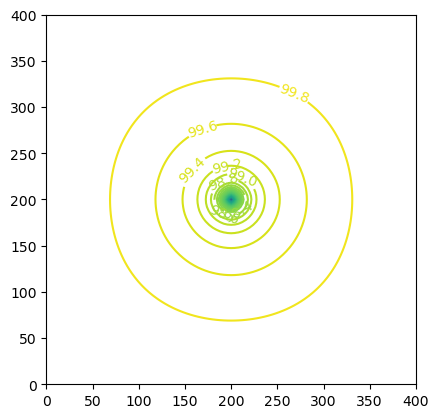

In [21]:
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
y = y[::-1]
c = plt.contour(x, y, h[0], np.arange(90, 100.1, 0.2))
plt.clabel(c, fmt="%2.1f")
plt.axis("scaled")

(0.0, 400.0, 0.0, 400.0)

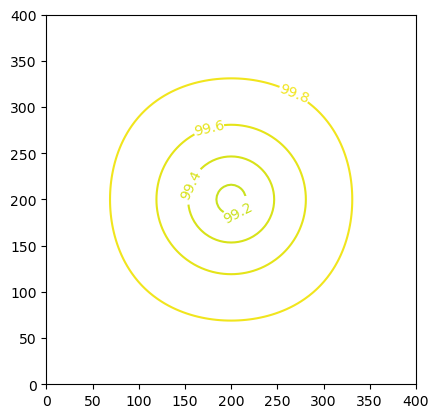

In [22]:
x = y = np.linspace(0, L, N)
y = y[::-1]
c = plt.contour(x, y, h[-1], np.arange(90, 100.1, 0.2))
plt.clabel(c, fmt="%1.1f")
plt.axis("scaled")

(0.0, 400.0, -47.5, -2.5)

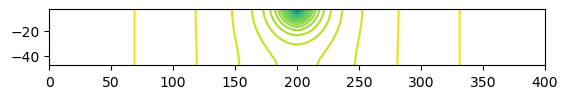

In [23]:
z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)
c = plt.contour(x, z, h[:, 50, :], np.arange(90, 100.1, 0.2))
plt.axis("scaled")

# __Post-Process_Flows__

## ___________________________reading the binary grid file

In [35]:
fname = os.path.join(workspace, f"{name}.dis.grb")
bgf = flopy.mf6.utils.MfGrdFile(fname)

bgf._datadict

{'NCELLS': 102010,
 'NLAY': 10,
 'NROW': 101,
 'NCOL': 101,
 'NJA': 689628,
 'XORIGIN': 0.0,
 'YORIGIN': 0.0,
 'ANGROT': 0.0,
 'DELR': array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 'DELC': array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 

## ___________________________reading cell budget

In [39]:
fname = os.path.join(workspace, f"{name}.cbb")
cbb = flopy.utils.CellBudgetFile(fname, precision="double")
cbb.headers.T

,64,5517216
kstp,1,1
kper,1,1
text,FLOW-JA-FACE,CHD
ncol,689628,101
nrow,1,101
nlay,-1,-10
imeth,1,6
delt,1.0,1.0
pertim,1.0,1.0
totim,1.0,1.0


In [40]:
flowja = cbb.get_data(text="FLOW-JA-FACE")[0][0, 0, :]
chdflow = cbb.get_data(text="CHD")[0]

In [41]:
k = 5
i = 50
j = 50
celln = k * N * N + i * N + j
ia, ja = bgf.ia, bgf.ja
print(f"Printing flows for cell {celln}")
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]
    print(f"Cell {celln} flow with cell {cellm} is {flowja[ipos]}")

Printing flows for cell 56105
Cell 56105 flow with cell 45904 is -0.5173461773371856
Cell 56105 flow with cell 56004 is 0.04821245255698159
Cell 56105 flow with cell 56104 is 0.04821245255698159
Cell 56105 flow with cell 56106 is 0.04827345085914203
Cell 56105 flow with cell 56206 is 0.04827345085914203
Cell 56105 flow with cell 66306 is 0.32526484558511587


In [ ]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass